In [1]:
import shap
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import warnings
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import re
import random
import itertools
import lime
from lime import lime_tabular
from sklearn.linear_model import Ridge

In [2]:
##method:A-learning method for continues and binary:

def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    
    
def squared_log_binary(predt,dtrain):
    predt=1.0/(1.0+np.exp(-predt))
    grad = gradient_version_binary(predt, dtrain)
    hess = hessian_version_binary(predt, dtrain)
    return grad, hess

def gradient_version_binary(predt, dtrain):
    y = dtrain.get_label()
    c=(X_train_trt+1.0)/2.0-pi_train
    return -y*c-c*np.exp(-c*predt)/((np.exp(-c*predt)+1))

def hessian_version_binary(predt, dtrain):
    y = dtrain.get_label()
    c=(X_train_trt+1.0)/2.0-pi_train
    return np.power(c,2)*np.exp(-c*predt)/((np.exp(-c*predt)+1)**2)


def rmsle_version_binary(predt, dtrain):
    y = dtrain.get_label()
    y_real=y.reshape((y.shape[0],))
    predt=1.0/(1+np.exp(-predt))
    c=(X_train_trt+1.0)/2.0-pi_train
    elements = -y*c*predt+np.log(1+np.exp(-c*predt))
    return 'lossE', float(np.sqrt(np.sum(elements) / len(y)))


##weight-learning:#########

def squared_log_weight_binary(predt, dtrain):
    """
    Compute gradient and hessian for Weight-learning loss for binary outcomes.
    """
    predt = 1.0 / (1.0 + np.exp(-predt))  # Sigmoid transformation
    grad = gradient_weight_binary(predt, dtrain)
    hess = hessian_weight_binary(predt, dtrain)
    return grad, hess

def gradient_weight_binary(predt, dtrain):
    """
    Compute the gradient for Weight-learning loss for binary outcomes.
    """
    y = dtrain.get_label()
    c = (1.0 - X_train_trt) / 2.0 + pi_train * X_train_trt  # Weighting factor
    grad = (-y * X_train_trt - X_train_trt * np.exp(-X_train_trt * predt) / (np.exp(-X_train_trt * predt) + 1)) / c
    return grad

def hessian_weight_binary(predt, dtrain):
    """
    Compute the hessian for Weight-learning loss for binary outcomes.
    """
    y = dtrain.get_label()
    c = (1.0 - X_train_trt) / 2.0 + pi_train * X_train_trt  # Weighting factor
    hess = (X_train_trt**2 * np.exp(-X_train_trt * predt) / (np.exp(-X_train_trt * predt) + 1)**2) / c
    return hess

def rmsle_weight_binary(predt, dtrain):
    """
    Compute the evaluation metric for Weight-learning loss for binary outcomes.
    """
    y = dtrain.get_label()
    predt = 1.0 / (1 + np.exp(-predt))  # Sigmoid transformation
    c = (1.0 - X_train_trt) / 2.0 + pi_train * X_train_trt  # Weighting factor
    elements = 1 / c * (-y * X_train_trt * predt + np.log(1 + np.exp(-X_train_trt * predt)))
    loss = float(np.sqrt(np.sum(elements) / len(y)))
    return 'Weight_loss', loss



In [3]:
train_num=random.sample(range(0,1000), 800)
test_num=list(set(range(0,1000))-set(train_num))
data_simulation = pd.read_csv('/ui/abv/liuzx18/project_shapley/simulation_data/simulation_beta2.csv').iloc[train_num,]
data_simulation_test = pd.read_csv('/ui/abv/liuzx18/project_shapley/simulation_data/simulation_beta2.csv').iloc[test_num,]
#del data_simulation['Unnamed: 0']
#del data_simulation_test['Unnamed: 0']
x_df=data_simulation[['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']]
X_=np.array(x_df)[:]
x_df_test=data_simulation_test[['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']]
X_test=np.array(x_df_test)

y_train=np.array(data_simulation[['y.binary']])
y_train=y_train.reshape(800,)


y_test=np.array(data_simulation_test[['y.binary']])
y_test=y_test.reshape(200,)
##training information:
trt_=data_simulation[['treatment']]
g_real=data_simulation[['sigpos']]
##testing information:
g_real_test=data_simulation_test[['sigpos']]




logreg = LogisticRegression()
logreg.fit(X_,trt_)
pi_x = logreg.predict_proba(X_)
pi_train=pi_x[:,1]



X_train_trt=np.where(trt_==1,1,-1)
X_train_trt=X_train_trt.reshape(800,)

dtrain = xgb.DMatrix(X_, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


x_train_feature_pd=x_df

In [4]:


best_params={'learning_rate':0.005,
     'booster':'gbtree',
     'max_depth':1,
     'alpha':5,
     'min_child_weight':5,
     'tree_method':'exact',
    'subsample':0.6,
    'max_delta_step':1,
    'gamma':1,
    'max_bin':128
    }



best_epoch=80
squared_log_binary
method = 'a'
if method == "a":
    model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=best_epoch,  # Use the best num_boost_round
    obj=squared_log_binary,
    feval=rmsle_version_binary
)
elif method =='w':
    model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=best_epoch,  # Use the best num_boost_round
    obj=squared_log_weight_binary,
    feval=rmsle_weight_binary
    )


# Predictions and Evaluation on Train Set
pred_train = model.predict(dtrain)
pred_train_prob = 1.0 / (1.0 + np.exp(-pred_train))  # Sigmoid transformation if needed
auc_train = roc_auc_score(g_real.astype(int), pred_train_prob)
print(f"Final Train AUC: {auc_train}")

# Predictions and Evaluation on Test Set
pred_test = model.predict(dtest)
pred_test_prob = 1.0 / (1.0 + np.exp(-pred_test))  # Sigmoid transformation if needed
auc_test = roc_auc_score(g_real_test.astype(int), pred_test_prob)
print(f"Final Test AUC: {auc_test}")


Final Train AUC: 0.7759631019387118
Final Test AUC: 0.7831313131313131


In [5]:
##tuning process :
num_samples_grid = [100, 500, 1000,1500]
kernel_width_grid = [0.1, 0.25, 0.5, 0.75, 1]
lambda_grid = [0.01, 0.1, 1, 10]
# Define the custom predict function
def custom_predict(data):
    dtrain = xgb.DMatrix(data)
    raw_predictions = model.predict(dtrain)
    probabilities = 1.0 / (1.0 + np.exp(-raw_predictions))  # Assuming logistic regression or similar output
    return np.vstack((1 - probabilities, probabilities)).T

# Custom function to compute R^2 and return it along with parameters
def evaluate_parameters(X, num_samples, kernel_width, lambda_val):
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X,
        mode='classification',
        feature_names=x_train_feature_pd.columns.tolist(),
        class_names=['Negative', 'Positive'],
        kernel_width=kernel_width,
        verbose=False
    )
    # Explain the first instance as a representative sample
    explanation = explainer.explain_instance(
        X_[0], custom_predict, num_features=10, top_labels=2,
        model_regressor=Ridge(alpha=lambda_val),
        num_samples=num_samples
    )
    r_squared = explanation.score  # Assuming binary classification
    return r_squared, num_samples, kernel_width, lambda_val

# Grid search over the parameter space
best_r2 = -np.inf
best_params = None

for num_samples, kernel_width, lambda_val in itertools.product(num_samples_grid, kernel_width_grid, lambda_grid):
    r2, n_samples, k_width, lam = evaluate_parameters(X_, num_samples, kernel_width, lambda_val)
    if r2 > best_r2:
        best_r2 = r2
        best_params = (n_samples, k_width, lam)

print(f"Best R^2: {best_r2}")
print(f"Best parameters: Num samples: {best_params[0]}, Kernel width: {best_params[1]}, Lambda: {best_params[2]}")


Best R^2: 0.5199349829666007
Best parameters: Num samples: 100, Kernel width: 0.75, Lambda: 0.01


In [6]:
def return_weights(exp):
    exp_list=exp.as_map()[1]
    exp_list=sorted(exp_list,key=lambda x:x[0])
    exp_weight=[x[1] for x in exp_list]
    return exp_weight




# Custom explainer class
class CustomLimeTabularExplainer(lime_tabular.LimeTabularExplainer):
    def explain_instance(self, data_row, predict_fn, labels=(1,), top_labels=None, num_features=10, num_samples=5000, distance_metric='euclidean', model_regressor=None):
        # Generate the explanation as usual
        explanation = super().explain_instance(
            data_row, predict_fn, labels=labels, top_labels=top_labels,
            num_features=num_features, num_samples=num_samples,
            distance_metric=distance_metric, model_regressor=model_regressor
        )

        # Access detailed results from the explanation
        local_model = explanation.local_exp[1] if 1 in explanation.local_exp else None
        intercept = explanation.intercept[1] if local_model else None
        coefficients = {self.feature_names[idx]: coef for idx, coef in local_model} if local_model else {}
        prediction_score = explanation.score if local_model else None
        local_pred = (1-explanation.local_pred) if local_model else None
        actual_pred = predict_fn(data_row.reshape(1, -1))[0, 1]  # Assuming the prediction for the positive class

        

        return intercept, coefficients, prediction_score, local_pred, actual_pred, explanation

explainer = CustomLimeTabularExplainer(
    training_data=np.array(X_),
    mode='classification',
    feature_names=x_train_feature_pd.columns.tolist(),
    class_names=['Receive control', 'Receive treatment'],
    verbose=False,
    kernel_width=0.5
)




weights =[]
r_2=[]
local_preds=[]


for x in X_[0:X_.shape[0]]:
    intercept, coefficients, prediction_score, local_pred, actual_pred, exp = explainer.explain_instance(
    x, custom_predict, num_features=10, top_labels=2, model_regressor=Ridge(alpha=0.01),
        num_samples=500
)

    exp_weight=return_weights(exp)
    weights.append(exp_weight)
    r_2.append(prediction_score)
    local_preds.append(local_pred[0])
    
lime_weight=pd.DataFrame(data=weights,columns=x_train_feature_pd.columns.tolist())








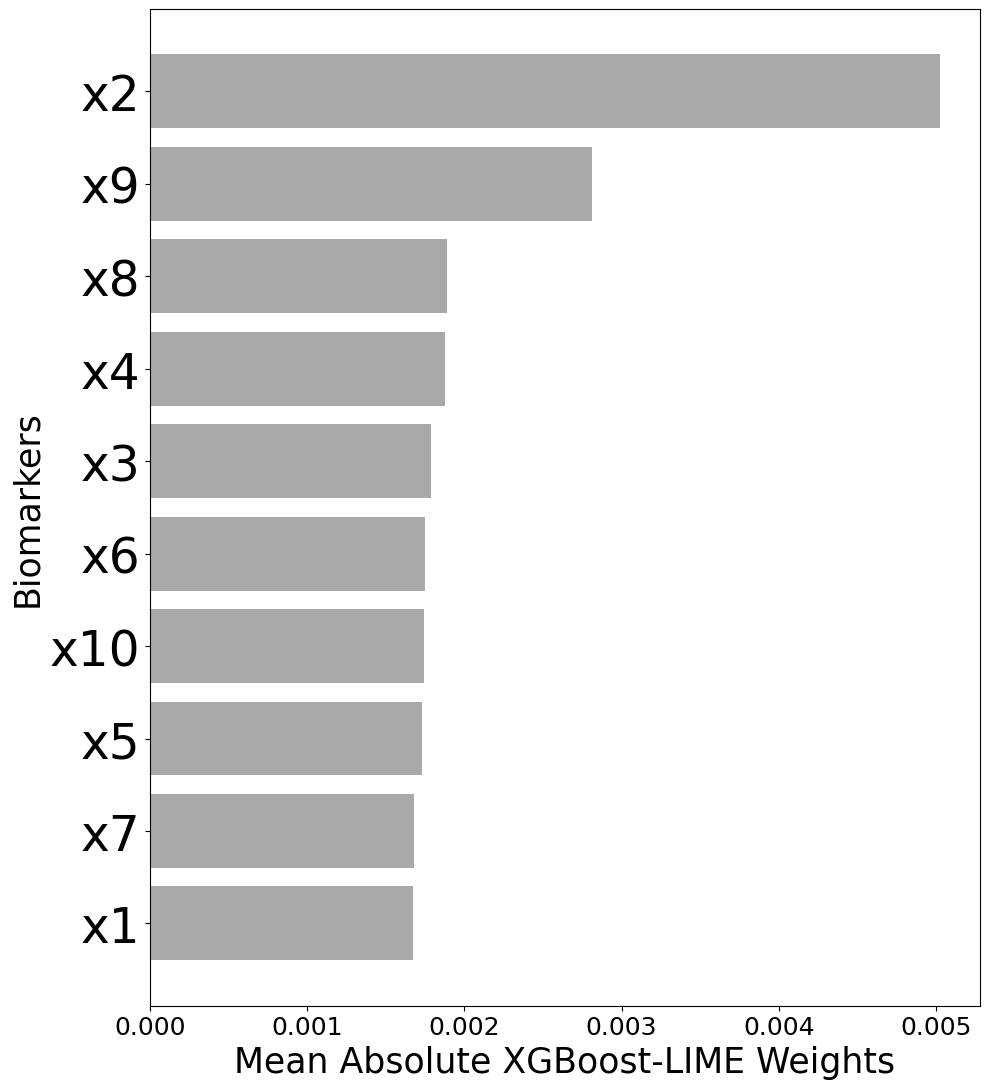

In [7]:


abs_mean = lime_weight.abs().mean(axis=0)
abs_mean = pd.DataFrame(data={'feature': abs_mean.index, 'abs_mean': abs_mean})
abs_mean = abs_mean.sort_values('abs_mean')



fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 11))
y_ticks = range(len(abs_mean))
y_labels = abs_mean.feature


# Plot using dark gray color
plt.barh(y=y_ticks, width=abs_mean.abs_mean, color='darkgray')
plt.yticks(ticks=y_ticks, labels=y_labels, size=35)
plt.xticks(size=18)
plt.title("")  # You can specify a title if needed
plt.ylabel("Biomarkers", size=25)  # Specify ylabel if necessary
plt.xlabel('Mean Absolute XGBoost-LIME Weights', size=25)

# Additional plot adjustments for better readability and publication quality
#ax.tick_params(axis='both', which='major', labelsize=18)
#plt.figure(figsize=(10, 8))
plt.tight_layout()  # Adjust layout to make sure everything fits without overlap
 


plt.show()  # Display the plot



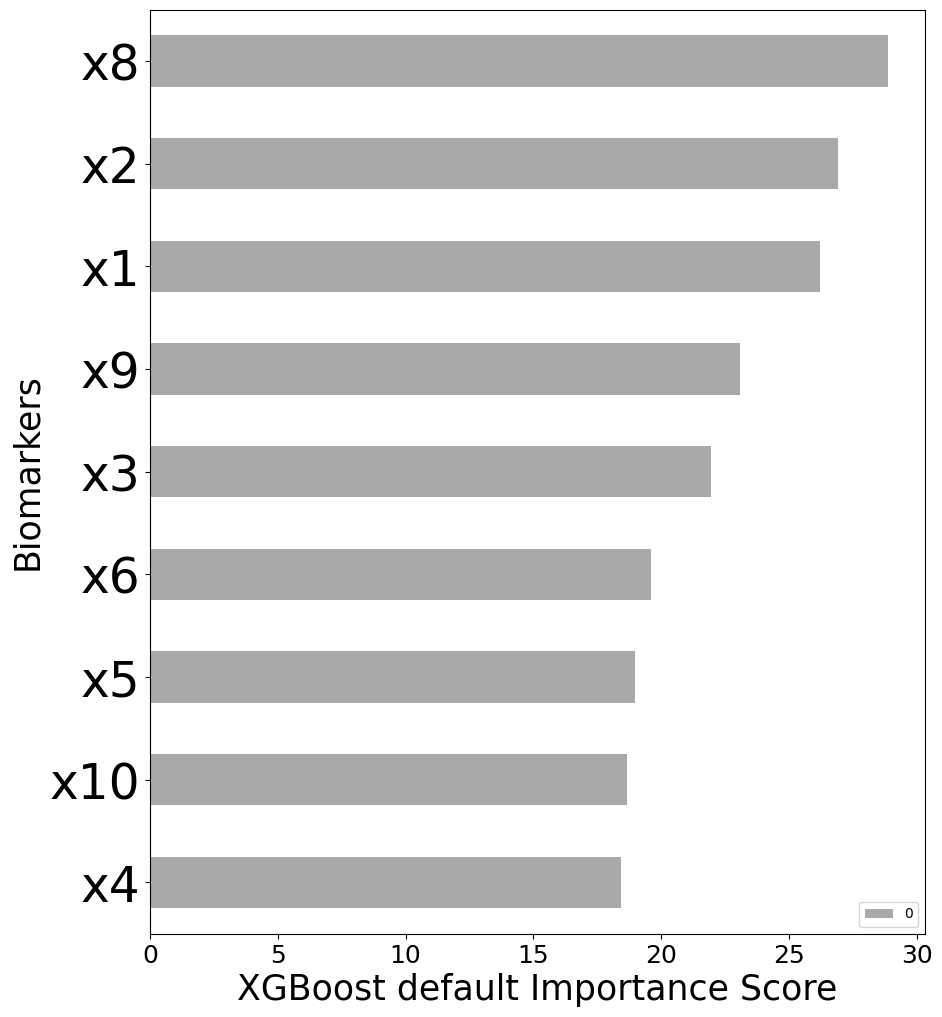

In [8]:
# Assuming 'model' and 'x_train_feature_pd' are already defined and set up
f_importance = model.get_score(importance_type='gain')

# Sort the features based on their importance scores
f_importance = {k: v for k, v in sorted(f_importance.items(), key=lambda item: item[1])}

# Create a DataFrame from the sorted dictionary
importance_df = pd.DataFrame.from_dict(data=f_importance, orient='index')

# Extract indices from feature names assuming they contain numbers
pd_colnames = []
for j in importance_df.index:   
    r = re.findall(r'\d+', j)    
    pd_colnames.append(int(r[0]))    

# Replace indices with actual feature names from your training DataFrame
importance_df.index = x_train_feature_pd.columns[pd_colnames]

# Create a horizontal bar plot with a dark gray color
importance_df.plot.barh(figsize=(10, 12), color='darkgray')  # Adjust figure size as needed

# Get current figure and axis for further customization
fig, ax = plt.gcf(), plt.gca()

# Modify plot parameters
#ax.tick_params(labelsize=18)  # Adjust tick label size
plt.xlabel("XGBoost default Importance Score", fontsize=25)  # Label for x-axis
plt.ylabel("Biomarkers", fontsize=25)  # Label for y-axis
plt.xticks(fontsize=18)  # Font size for x-ticks
plt.yticks(fontsize=35)  # Font size for y-ticks



plt.show()  # Display the plot

In [9]:
explainer_tree = shap.TreeExplainer(model)
expected_value = explainer_tree.expected_value
shap_values_tree = explainer_tree (x_train_feature_pd)
shap.force_plot(expected_value, shap_values_tree.values[0,:], x_train_feature_pd.iloc[0,:])

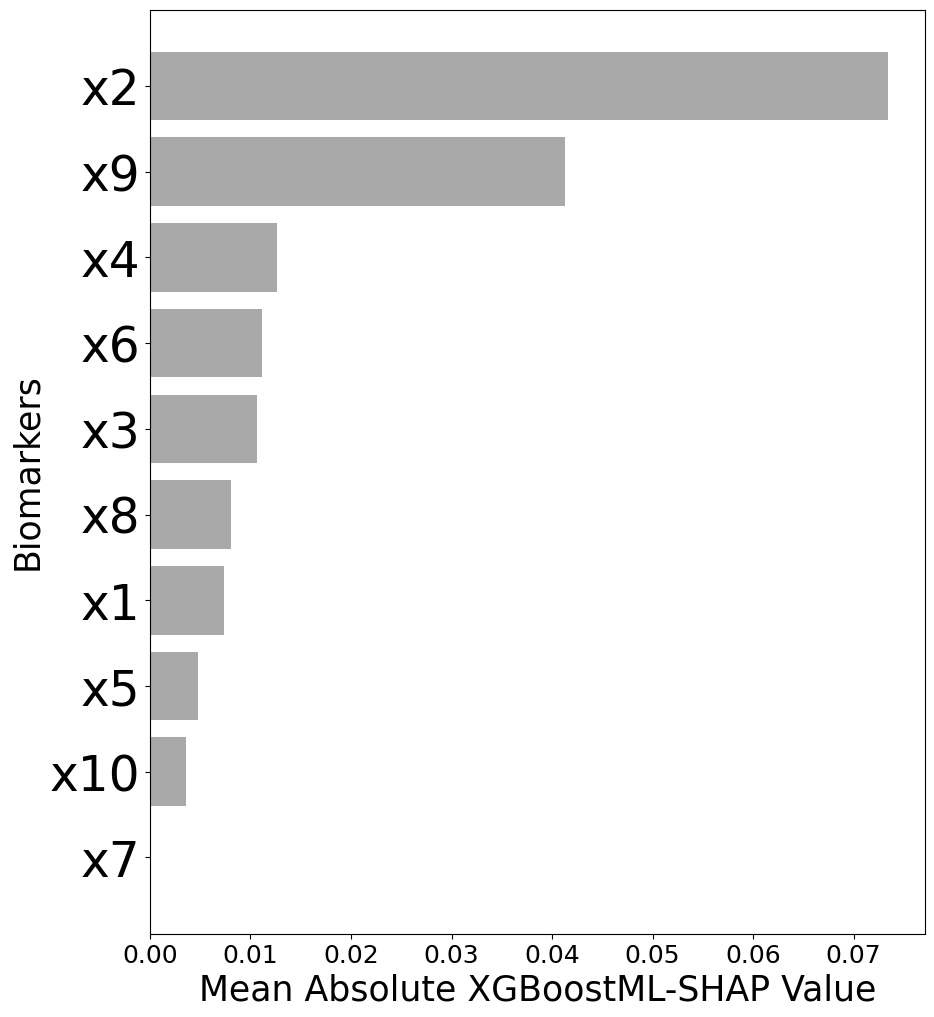

In [10]:


mean_shap_values = np.abs(shap_values_tree.values).mean(axis=0)
features = x_train_feature_pd.columns

# Create a DataFrame for plotting
shap_df = pd.DataFrame({
    'Feature': features,
    'Mean SHAP Value': mean_shap_values
}).sort_values(by='Mean SHAP Value', ascending=True)

# Plot using Matplotlib directly
plt.figure(figsize=(10, 12))
plt.barh(shap_df['Feature'], shap_df['Mean SHAP Value'], color='darkgray')
plt.xlabel('Mean Absolute XGBoostML-SHAP Value', fontsize=25)
plt.ylabel('Biomarkers', fontsize=25)
plt.title('')
plt.xticks(fontsize=18)  # Font size for x-ticks
plt.yticks(fontsize=35)  # Font size for y-ticks

plt.show()

